In [1]:
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.utils import shuffle
from util import init_weight, all_parity_pairs_with_sequence_labels

shape y: (12, 1, 2)
i: 0 cost: 2841.82932722 classification rate: 0.503902439024
shape y: (12, 1, 2)
i: 1 cost: 2837.40267443 classification rate: 0.495853658537
shape y: (12, 1, 2)
i: 2 cost: 2834.6351515 classification rate: 0.492195121951
shape y: (12, 1, 2)
i: 3 cost: 2831.8237551 classification rate: 0.5
shape y: (12, 1, 2)
i: 4 cost: 2829.54637666 classification rate: 0.500731707317
shape y: (12, 1, 2)
i: 5 cost: 2828.8796175 classification rate: 0.5
shape y: (12, 1, 2)
i: 6 cost: 2828.14797966 classification rate: 0.500975609756
shape y: (12, 1, 2)
i: 7 cost: 2826.97302338 classification rate: 0.5
shape y: (12, 1, 2)
i: 8 cost: 2827.09313667 classification rate: 0.5
shape y: (12, 1, 2)
i: 9 cost: 2826.2649186 classification rate: 0.5
shape y: (12, 1, 2)
i: 10 cost: 2824.76266692 classification rate: 0.5
shape y: (12, 1, 2)
i: 11 cost: 2823.93077067 classification rate: 0.5
shape y: (12, 1, 2)
i: 12 cost: 2822.00780204 classification rate: 0.5
shape y: (12, 1, 2)
i: 13 cost: 2819

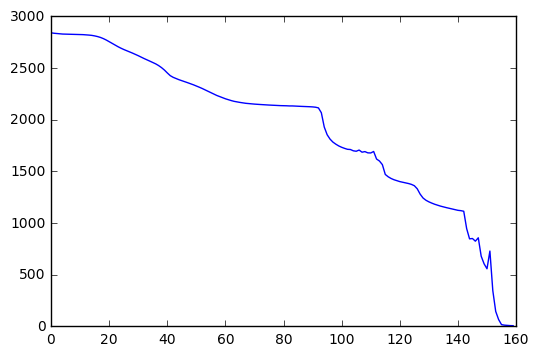

In [7]:
class SimpleRNN(object):
    def __init__(self, M):
        self.M = M
        
    def fit(self, X, Y, learning_rate=10e-1, mu=0.99, reg=1.0, activation=T.tanh, epochs=100, show_fig=False):
        D = X[0].shape[1] # X is of size N x T(n) x D
        K = len(set(Y.flatten()))
        N = len(Y)
        M = self.M
        self.f = activation

        # initial weights
        Wx = init_weight(D, M)
        Wh = init_weight(M, M)
        bh = np.zeros(M)
        h0 = np.zeros(M)
        Wo = init_weight(M, K)
        bo = np.zeros(K)

        # make them theano shared
        self.Wx = theano.shared(Wx)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.h0 = theano.shared(h0)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.Wx, self.Wh, self.bh, self.h0, self.Wo, self.bo]

        thX = T.fmatrix('X')
        thY = T.ivector('Y')

        def recurrence(x_t, h_t1):
            # returns h(t), y(t)
            h_t = self.f(x_t.dot(self.Wx) + h_t1.dot(self.Wh) + self.bh)
            y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo)
            return h_t, y_t

        [h, y], _ = theano.scan(
            fn=recurrence,
            outputs_info=[self.h0, None],
            sequences=thX,
            n_steps=thX.shape[0],
        )

        py_x = y[:, 0, :]
        prediction = T.argmax(py_x, axis=1)

        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]

        self.predict_op = theano.function(inputs=[thX], outputs=prediction)
        self.train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction, y],
            updates=updates
        )

        costs = []
        for i in xrange(epochs):
            X, Y = shuffle(X, Y)
            n_correct = 0
            cost = 0
            for j in xrange(N):
                c, p, rout = self.train_op(X[j], Y[j])
                # print "p:", p
                cost += c
                if p[-1] == Y[j,-1]:
                    n_correct += 1
            print "shape y:", rout.shape
            print "i:", i, "cost:", cost, "classification rate:", (float(n_correct)/N)
            costs.append(cost)
            if n_correct == N:
                break

        if show_fig:
            plt.plot(costs)
            plt.show()



def parity(B=12, learning_rate=10e-5, epochs=200):
    X, Y = all_parity_pairs_with_sequence_labels(B)

    rnn = SimpleRNN(4)
    rnn.fit(X, Y, learning_rate=learning_rate, epochs=epochs, activation=T.nnet.sigmoid, show_fig=True)


if __name__ == '__main__':
    parity()